In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib import collections as mc
import networkx as nx
# import nxpd as nxpd  # pip install nxpd if you haven't
import nxpd
import community as comm
import GraphTools as gt
from collections import deque
from itertools import product

In [28]:
# get Korean language to show on matplotlib
import matplotlib
import matplotlib.font_manager as fm
font_location = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc("font",family=font_name)

In [29]:
df = pd.read_csv("../data/p_store_ordersub2019.csv")

In [30]:
df.head()

,orderno,seq,branch,saledate,saletime,gcode,mcode,mname,qty,unitprice,amount,dcamount
0,201903140001,1,BK0008,20190314,1411,1100.0,1108,봉주르크로아상,1,1300.0,1300.0,0.0
1,201903140001,2,BK0008,20190314,1411,1100.0,394,수제쿠키,1,1000.0,1000.0,0.0
2,201904160001,1,BK0008,20190416,1224,1400.0,980,자몽에이드,1,3000.0,3000.0,0.0
3,201906110001,1,BK0008,20190611,1756,1100.0,385,단팥빵,1,1200.0,1200.0,0.0
4,201906110001,2,BK0008,20190611,1756,1100.0,392,소보로빵,1,1200.0,1200.0,0.0


In [31]:
def clean_df(df):
    """
    Filters and cleans menu names so that varieties of the same names are aggegrated to one.
    
    Parameters
    ==========
    df: Pandas DataFrame
        Raw sales dataframe from .csv file
    
    Returns
    =======
    Pandas DataFrame
    """
    # drop stores with different menus
    df = df[(df["branch"] != "bk0026") 
         & (df["branch"] != "BK0021")].copy()
    
    # convert date and time to datetime object
    df["sale_datetime"] = df["saledate"].astype("str") + df["saletime"].astype("str").str.zfill(4)
    df["sale_datetime"] = pd.to_datetime(df["sale_datetime"], format='%Y%m%d%H%M')
    
    # clean up discount names
    cleanup_names = {
    "mnames": {"ice- 아메리카노": "아이스아메리카노",
               "ice-아메리카노(할인)": "(500원할인)아이스아메리카노",
               "(할인)ice-아메리카노": "(500원할인)아이스아메리카노",
               "(~10/15할인)ice-아메리카노":"(500원할인)아이스아메리카노",
               "(할인)아이스아메리카노": "(500원할인)아이스아메리카노",
               "(할인)아메리카노":"(500원할인)아메리카노",
               "아메리카노(할인)":"(500원할인)아메리카노",
               "(~10/15할인)아메리카노":"(500원할인)아메리카노"}}
    
    # clean up "ice-" menu names
    df["mname"].replace(regex={r"ice(-)?(\s)?":'아이스'}, inplace=True)
    
    # drop two values with na
    df.dropna(inplace=True)

    return df

In [32]:
menu_df = clean_df(df)

Text(0, 0.5, 'Count')

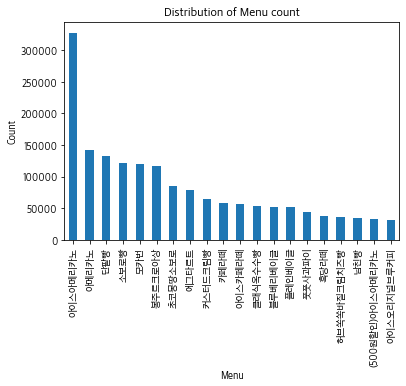

In [33]:
# Popular menu items
fig, ax = plt.subplots()
menu_df["mname"].value_counts()[:20].plot(kind="bar", ax=ax)
ax.set_title("Distribution of Menu count")
ax.set_xlabel("Menu")
ax.set_ylabel("Count")

In [34]:
for name, value in zip(menu_df["mname"].value_counts().index, menu_df["mname"].value_counts()):
    print(f"{name}: {value}")

아이스아메리카노: 327594
아메리카노: 141953
단팥빵: 131954
소보로빵: 121129
모카번: 119826
봉주르크로아상: 117365
초코몽땅소보로: 85508
에그타르트: 79165
커스터드크림빵: 64623
카페라떼: 57996
아이스카페라떼: 55867
클래식옥수수빵: 54204
블루베리베이글: 52186
플레인베이글: 51702
풋풋사과파이: 43763
흑당라떼: 38073
허브쏙쏙바질크림치즈빵: 35909
남친빵: 35062
(500원할인)아이스아메리카노: 32724
아이스오리지널브루커피: 31665
버터크림빵: 31194
블루베리스콘: 30524
매콤부추고로케: 28912
(500원할인)아메리카노: 28211
촉촉한치즈타르트: 26777
SizeUP: 24400
호두타르트: 23036
NEW텔라번: 21585
아이스바닐라라떼: 21157
크랜베리베이글: 21031
부드러운피자번: 19440
묶음빵: 19344
미니잡곡호두식빵: 18716
크림치즈모카번: 18572
미니쌀우유식빵: 18418
샷하나: 17730
복숭아아이스티: 16983
미니먹물치즈식빵: 16575
캐리어: 15568
아이스달콤라떼: 15521
못난이치즈감자빵: 13422
왕꽈배기: 13305
네입에피자: 13143
모카봉주르크로와상: 13059
보스턴핫도그: 11393
브라우니타르트: 11290
단팥찹쌀도넛: 11270
바닐라라떼: 10983
비닐봉투: 10144
스위트콘브레드: 9833
크랜베리스콘: 9811
메이플파이: 9647
초코청크머핀: 8920
샷 추가: 8700
씨앗쿠키: 8625
달콤라떼: 8276
초코달팽이: 7984
초콜릿커스타드크림빵: 7980
바질쏙쏙갈릭바게트: 7849
초코찐득브라우니: 7674
(할인)아메리카노: 7657
치즈베이글: 7566
먹물치즈콕콕브레드: 7440
오리지널브루커피: 7141
바싹치즈볼: 6680
치즈콕콕브레드: 6625
Size Up: 6620
(S)아메리카노: 6419
연하게: 6393
얼음추가: 6178
얼룩초코크로

In [35]:
menu_df["mname"].nunique()

398

In [36]:
menu_df.head()

,orderno,seq,branch,saledate,saletime,gcode,mcode,mname,qty,unitprice,amount,dcamount,sale_datetime
0,201903140001,1,BK0008,20190314,1411,1100.0,1108,봉주르크로아상,1,1300.0,1300.0,0.0,2019-03-14 14:11:00
1,201903140001,2,BK0008,20190314,1411,1100.0,394,수제쿠키,1,1000.0,1000.0,0.0,2019-03-14 14:11:00
2,201904160001,1,BK0008,20190416,1224,1400.0,980,자몽에이드,1,3000.0,3000.0,0.0,2019-04-16 12:24:00
3,201906110001,1,BK0008,20190611,1756,1100.0,385,단팥빵,1,1200.0,1200.0,0.0,2019-06-11 17:56:00
4,201906110001,2,BK0008,20190611,1756,1100.0,392,소보로빵,1,1200.0,1200.0,0.0,2019-06-11 17:56:00


In [37]:
def get_agg(df):
    agg_df = df.groupby(["orderno","branch"])["mname"].apply(lambda x: x.tolist()).reset_index()
    return agg_df
agg_df = get_agg(menu_df)

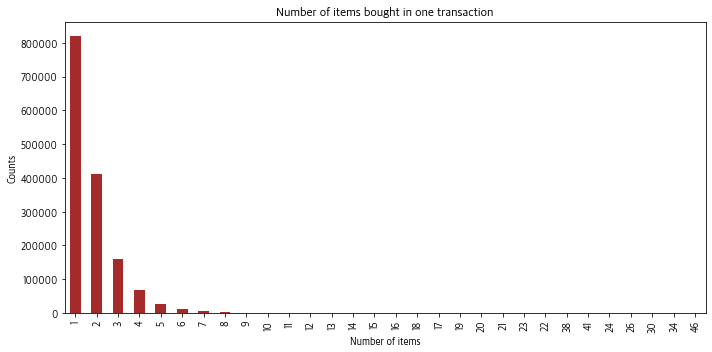

In [187]:
fig, ax = plt.subplots(figsize=(10,5))
agg_df["mname"].apply(len).value_counts().plot(kind="bar", ax=ax, color="brown")
ax.set_title("Number of items bought in one transaction")
ax.set_xlabel("Number of items")
ax.set_ylabel("Counts")
plt.tight_layout()
plt.savefig("../plots2/basket_distribution.png")

In [245]:
## BK0020 specific
bk0020_df = menu_df[menu_df["branch"]=="BK0020"]
agg_df20 = get_agg(bk0020_df)

In [247]:
agg_df20.head()

,orderno,branch,mname
0,201901010001,BK0020,"[달콤크림라떼, 아메리카노]"
1,201901010002,BK0020,"[리얼버터크루아상, 얼룩초코크로와상, 카페라떼]"
2,201901010003,BK0020,"[NEW텔라번, (500원할인)아메리카노]"
3,201901010004,BK0020,"[커스터드크림빵, NEW텔라번, 모카번, 소보로빵, 블루베리머핀, 초코청크머핀, 솔..."
4,201901010005,BK0020,"[허브쏙쏙바질크림치즈빵, 풋풋사과파이, 튀김소보루, 카페라떼, 복숭아아이스티, 애플주스]"


In [39]:
menu_list = np.array(menu_df["mname"].value_counts().index)
menu_list[:100]

array(['아이스아메리카노', '아메리카노', '단팥빵', '소보로빵', '모카번', '봉주르크로아상', '초코몽땅소보로',
       '에그타르트', '커스터드크림빵', '카페라떼', '아이스카페라떼', '클래식옥수수빵', '블루베리베이글',
       '플레인베이글', '풋풋사과파이', '흑당라떼', '허브쏙쏙바질크림치즈빵', '남친빵',
       '(500원할인)아이스아메리카노', '아이스오리지널브루커피', '버터크림빵', '블루베리스콘', '매콤부추고로케',
       '(500원할인)아메리카노', '촉촉한치즈타르트', 'SizeUP', '호두타르트', 'NEW텔라번',
       '아이스바닐라라떼', '크랜베리베이글', '부드러운피자번', '묶음빵', '미니잡곡호두식빵', '크림치즈모카번',
       '미니쌀우유식빵', '샷하나', '복숭아아이스티', '미니먹물치즈식빵', '캐리어', '아이스달콤라떼',
       '못난이치즈감자빵', '왕꽈배기', '네입에피자', '모카봉주르크로와상', '보스턴핫도그', '브라우니타르트',
       '단팥찹쌀도넛', '바닐라라떼', '비닐봉투', '스위트콘브레드', '크랜베리스콘', '메이플파이', '초코청크머핀',
       '샷 추가', '씨앗쿠키', '달콤라떼', '초코달팽이', '초콜릿커스타드크림빵', '바질쏙쏙갈릭바게트',
       '초코찐득브라우니', '(할인)아메리카노', '치즈베이글', '먹물치즈콕콕브레드', '오리지널브루커피', '바싹치즈볼',
       '치즈콕콕브레드', 'Size Up', '(S)아메리카노', '연하게', '얼음추가', '얼룩초코크로와상',
       '자몽에이드', '인생피자베이글', '아이스초코라떼', '리얼버터크루아상', '튀김소보루', '드시고감',
       '청포도에이드', '하나반', '딸기라떼', '아이스티(복숭아)', '갈릭봉주르크로와상', '잉글리쉬머핀',
       '아메리카노(할인)', '아이스달콤크림라떼', '애플시나몬머

In [40]:
menu_list.shape

(398,)

In [41]:
agg_df

,orderno,branch,mname
0,201901010001,BK0010,[소보로빵]
1,201901010001,BK0018,"[아이스아메리카노, 카페라떼]"
2,201901010001,BK0019,[네입에피자]
3,201901010001,BK0020,"[달콤크림라떼, 아메리카노]"
4,201901010001,BK0022,[아메리카노]
...,...,...,...
1507031,201912310533,BK0019,[블루베리스콘]
1507032,201912310534,BK0019,[촉촉한치즈타르트]
1507033,201912310535,BK0019,[블루베리스콘]
1507034,201912310536,BK0019,[에그타르트]


In [42]:
agg_df["mname"]

0                    [소보로빵]
1          [아이스아메리카노, 카페라떼]
2                   [네입에피자]
3           [달콤크림라떼, 아메리카노]
4                   [아메리카노]
                 ...       
1507031            [블루베리스콘]
1507032          [촉촉한치즈타르트]
1507033            [블루베리스콘]
1507034             [에그타르트]
1507035            [블루베리스콘]
Name: mname, Length: 1507036, dtype: object

In [43]:
menu_df.head(2)

,orderno,seq,branch,saledate,saletime,gcode,mcode,mname,qty,unitprice,amount,dcamount,sale_datetime
0,201903140001,1,BK0008,20190314,1411,1100.0,1108,봉주르크로아상,1,1300.0,1300.0,0.0,2019-03-14 14:11:00
1,201903140001,2,BK0008,20190314,1411,1100.0,394,수제쿠키,1,1000.0,1000.0,0.0,2019-03-14 14:11:00


In [44]:
def count_vectorize(agg_df, menu_df):
    # get master list initiate blank count vector
    menu_list = np.array(menu_df["mname"].value_counts().index)
    cv = np.zeros([len(agg_df), len(menu_list)])
    # map count into vector
    for idx, row in agg_df.iterrows():
        for menu in row["mname"]:
            cv[idx, np.where(menu_list==menu)[0]] = 1
    return cv
        

In [45]:
count_vect = count_vectorize(agg_df, menu_df)

In [46]:
count_df = pd.DataFrame(count_vect, columns=menu_list)
count_df

,아이스아메리카노,아메리카노,단팥빵,소보로빵,모카번,봉주르크로아상,초코몽땅소보로,에그타르트,커스터드크림빵,카페라떼,...,소세지브리또,블루베리베이글세트,크라상샌드위치,추가,수정이퇴근,19/08/23 행사,초콜릿커스터드크림빵,불고기브리또,초코베이글,선결제
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1507032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1507033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1507034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
count_df.head()

,아이스아메리카노,아메리카노,단팥빵,소보로빵,모카번,봉주르크로아상,초코몽땅소보로,에그타르트,커스터드크림빵,카페라떼,...,소세지브리또,블루베리베이글세트,크라상샌드위치,추가,수정이퇴근,19/08/23 행사,초콜릿커스터드크림빵,불고기브리또,초코베이글,선결제
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# count_df.to_pickle("count_df.pkl")

In [48]:
count_vect.shape

(1507036, 398)

In [49]:
count_df[count_df["아이스아메리카노"]==1]

,아이스아메리카노,아메리카노,단팥빵,소보로빵,모카번,봉주르크로아상,초코몽땅소보로,에그타르트,커스터드크림빵,카페라떼,...,소세지브리또,블루베리베이글세트,크라상샌드위치,추가,수정이퇴근,19/08/23 행사,초콜릿커스터드크림빵,불고기브리또,초코베이글,선결제
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506982,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1506987,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1506993,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1506995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# make function to calculate recursive counts
def recursive_counts(menu_list, count_df):
    diag_list = []
    for menu in menu_list:
        count = 0
        for row in count_df[count_df[menu]==1].values:
            if row.sum() < 2:
                count += 1
        diag_list.append(count)
    return diag_list

In [52]:
def cv_to_adj(cv):
    # make dictionary of arrays for each menu
    menu_dict = {}
    for menu in cv.columns:
        menu_dict[menu] = cv[cv[menu]==1].sum()
    # import dictionary to pandas
    adj_matrix = pd.DataFrame.from_dict(menu_dict)
    # get recursive count list
    diag_list = recursive_counts(menu_list, cv)
    # replace diagonals with recursive count
    np.fill_diagonal(adj_matrix.values, diag_list)
    return adj_matrix

In [53]:
adj_matrix = cv_to_adj(count_df)

In [56]:
adj_matrix.head()

,아이스아메리카노,아메리카노,단팥빵,소보로빵,모카번,봉주르크로아상,초코몽땅소보로,에그타르트,커스터드크림빵,카페라떼,...,소세지브리또,블루베리베이글세트,크라상샌드위치,추가,수정이퇴근,19/08/23 행사,초콜릿커스터드크림빵,불고기브리또,초코베이글,선결제
아이스아메리카노,188594.0,13247.0,6936.0,6937.0,7757.0,7178.0,4693.0,5165.0,4322.0,2998.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
아메리카노,13247.0,72789.0,5849.0,5041.0,4917.0,3969.0,2207.0,2137.0,2207.0,5093.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
단팥빵,6936.0,5849.0,31631.0,32476.0,15743.0,15605.0,11234.0,3773.0,16330.0,1950.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
소보로빵,6937.0,5041.0,32476.0,27468.0,14659.0,14754.0,11294.0,3680.0,11437.0,2041.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
모카번,7757.0,4917.0,15743.0,14659.0,30076.0,14258.0,10006.0,6744.0,8248.0,2331.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
#adj_matrix.to_pickle("adj_matrix.pkl")

In [ ]:
# Graph object on full matrix
# Warning: will take a long time to render plot and will not be interpretable
# g_matrix = adj_matrix.values
# G = nx.Graph(g_matrix)
# G.graph['rankdir'] = 'LR'

#nxpd.draw(G, show='ipynb')

In [190]:
# make subset of adj matrix and plot
sub_matrix = adj_matrix.iloc[:10,:10].values

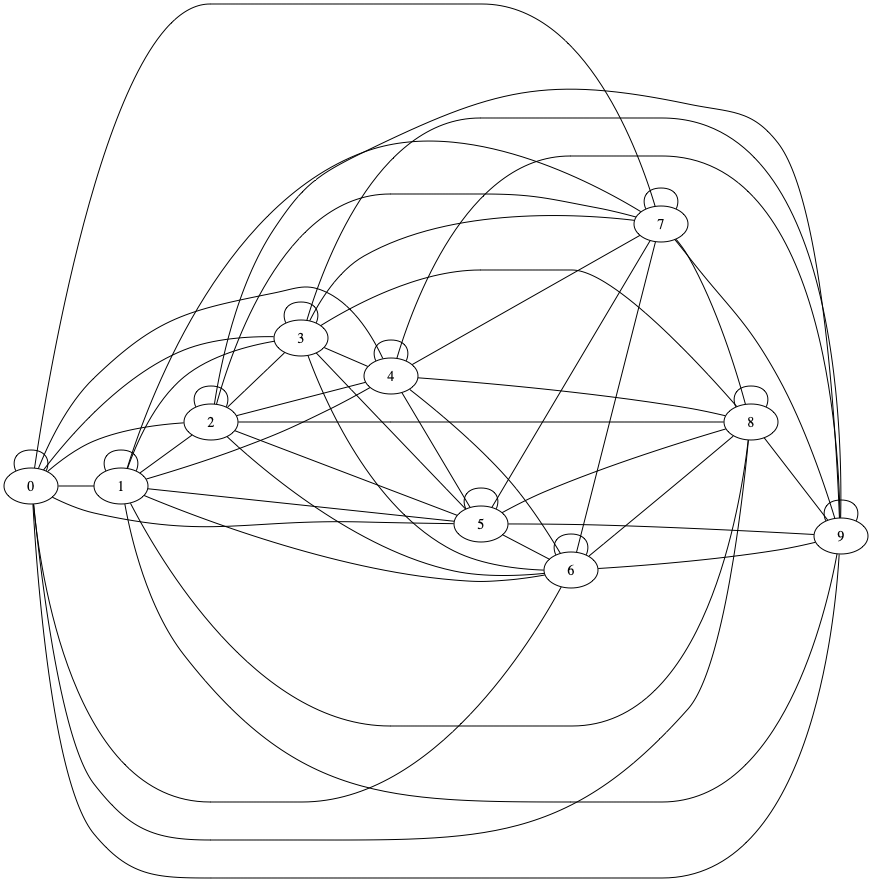

In [191]:
G1 = nx.Graph(sub_matrix)
G1.graph['rankdir'] = 'LR'
nxpd.draw(G1, show='ipynb')

In [ ]:
degree_centralities = gt.format_dict_of_floats(nx.degree_centrality(G1))
gt.label_nodes(G1, degree_centralities)
nxpd.draw(G1, show='ipynb')

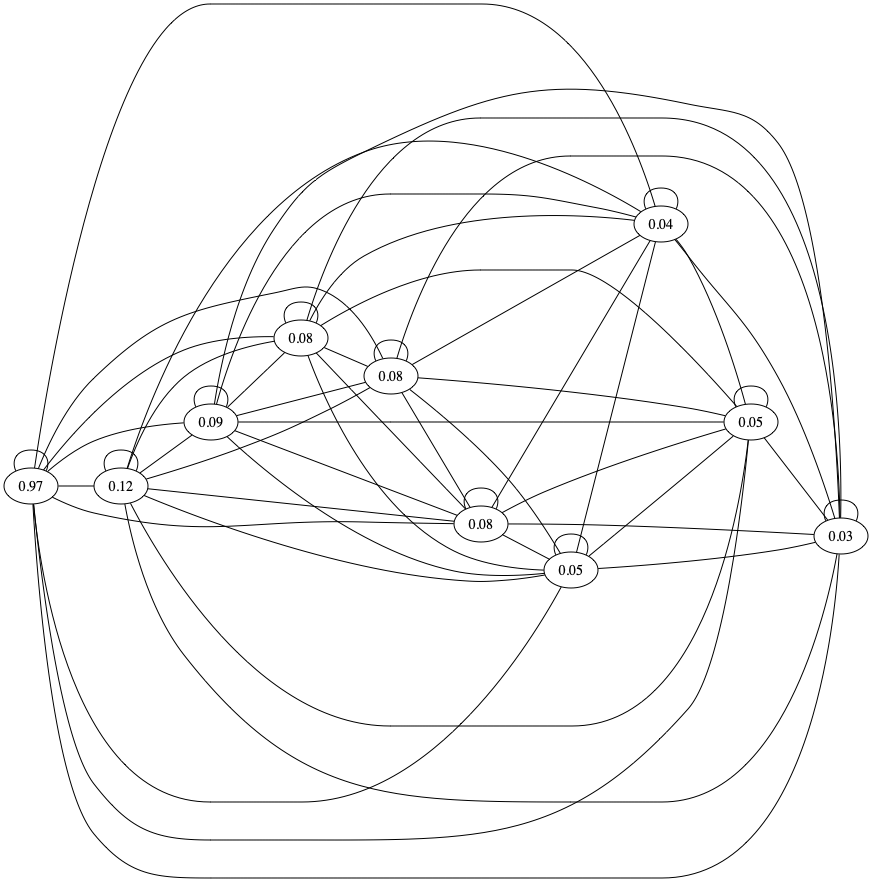

In [192]:
G1.graph['rankdir'] = 'LR'
eigen_centralities = gt.format_dict_of_floats(nx.eigenvector_centrality(G1, weight="weight"))
#gt.label_nodes(G1, eigen_centralities)
#nxpd.draw(G1, show='ipynb')

In [196]:
G = nx.Graph(adj_matrix)
eigen_centralities = gt.format_dict_of_floats(nx.eigenvector_centrality(G, weight="weight"))



In [197]:
eigen_centralities

{'아이스아메리카노': '0.95',
 '아메리카노': '0.13',
 '단팥빵': '0.11',
 '소보로빵': '0.10',
 '모카번': '0.10',
 '봉주르크로아상': '0.09',
 '초코몽땅소보로': '0.06',
 '에그타르트': '0.05',
 '커스터드크림빵': '0.06',
 '카페라떼': '0.03',
 '아이스카페라떼': '0.05',
 '클래식옥수수빵': '0.04',
 '블루베리베이글': '0.04',
 '플레인베이글': '0.04',
 '풋풋사과파이': '0.03',
 '흑당라떼': '0.03',
 '허브쏙쏙바질크림치즈빵': '0.03',
 '남친빵': '0.03',
 '(500원할인)아이스아메리카노': '0.02',
 '아이스오리지널브루커피': '0.00',
 '버터크림빵': '0.03',
 '블루베리스콘': '0.02',
 '매콤부추고로케': '0.02',
 '(500원할인)아메리카노': '0.01',
 '촉촉한치즈타르트': '0.02',
 'SizeUP': '0.09',
 '호두타르트': '0.02',
 'NEW텔라번': '0.01',
 '아이스바닐라라떼': '0.02',
 '크랜베리베이글': '0.01',
 '부드러운피자번': '0.01',
 '묶음빵': '0.00',
 '미니잡곡호두식빵': '0.01',
 '크림치즈모카번': '0.01',
 '미니쌀우유식빵': '0.01',
 '샷하나': '0.06',
 '복숭아아이스티': '0.02',
 '미니먹물치즈식빵': '0.01',
 '캐리어': '0.05',
 '아이스달콤라떼': '0.01',
 '못난이치즈감자빵': '0.01',
 '왕꽈배기': '0.01',
 '네입에피자': '0.01',
 '모카봉주르크로와상': '0.01',
 '보스턴핫도그': '0.01',
 '브라우니타르트': '0.01',
 '단팥찹쌀도넛': '0.01',
 '바닐라라떼': '0.01',
 '비닐봉투': '0.01',
 '스위트콘브레드': '0.01',
 '크랜베리스콘': '0.01',
 '메이플파이'

In [205]:
eigen_df = pd.DataFrame(eigen_centralities, index=["eigen"]).T

In [239]:
eigen_df["eigen"] = eigen_df["eigen"].astype("float64")

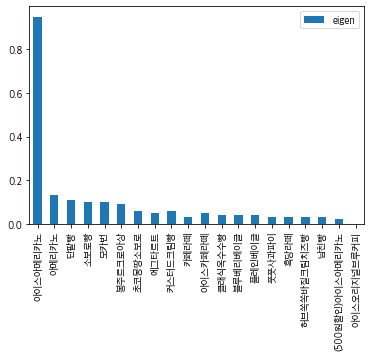

In [243]:
eigen_df[:20].plot(kind="bar")

In [ ]:
tm = np.where(sub_matrix>1500, sub_matrix, 0)

In [ ]:
tm

In [ ]:
sub_matrix = adj_matrix.iloc[1:11,1:11].values

In [ ]:
# make subset of adj matrix and plot


G1 = nx.Graph(tm)

pos = nx.spring_layout(G1)

# node values to cmap
node_values = np.array(list(nx.eigenvector_centrality(G1, weight="weight").values()))
node_colors = np.log(node_values)

# edge weights to cmap
weights = np.array([d["weight"] for (u, v, d) in G1.edges(data=True)])
edge_colors = np.log(weights)

options = {
    "node_color": node_colors,
    "edge_color": edge_colors,
    "width": 2,
    "cmap": plt.cm.Reds,
    "edge_cmap": plt.cm.Reds,
    "with_labels": True
}

nx.draw(G1, pos, **options)
plt.show()

In [ ]:
for i, name in enumerate(adj_matrix.columns[1:11]):
    print(i, name)

In [ ]:
G1.edges(data=True)

In [248]:
combos20 = agg_df20["mname"].value_counts()

In [60]:
combos = agg_df["mname"].value_counts()

In [164]:
!ls

GraphTools.py         clustering.ipynb      store_dataframe.pkl
LSTM_timeseries.ipynb combos.csv            timeseries.ipynb
__pycache__           combos.pkl            top_menu_sets.pkl
adj_matrix.pkl        count_df.pkl          weather_2019.pkl
bk0020_series.csv     darksky_api.ipynb


In [165]:
#combos.to_csv("combos.csv")
combos

[아이스아메리카노]                                            187685
[아메리카노]                                                72353
[단팥빵]                                                  31574
[모카번]                                                  30049
[카페라떼]                                                 29640
                                                       ...  
[초코몽땅소보로, 모카번, 허브쏙쏙바질크림치즈빵, 남친빵, 촉촉한치즈타르트, 초코 마카롱]         1
[밀크티, 페퍼민트, 아이스변경]                                         1
[단팥빵, 봉주르크로아상, 남친빵, 커스터드크림빵, 소보로빵]                         1
[촉촉한치즈타르트, 호두타르트, 씨앗쿠키, 크랜베리스콘]                            1
[크림치즈모카번, 유자에이드, 드립백서비스]                                   1
Name: mname, Length: 194681, dtype: int64

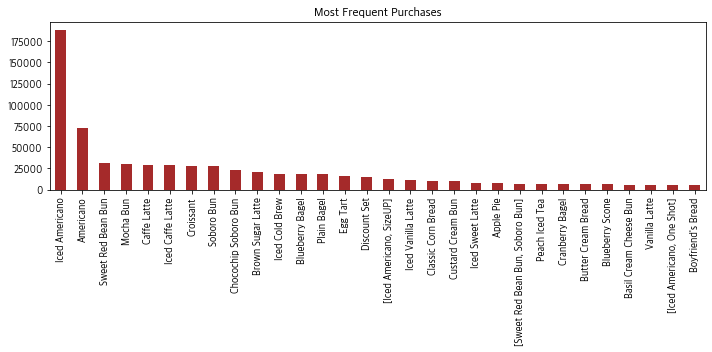

In [174]:
translated = [
    "Iced Americano",
    "Americano",
    "Sweet Red Bean Bun",
    "Mocha Bun",
    "Caffe Latte",
    "Iced Caffe Latte",
    "Croissant",
    "Soboro Bun",
    "Chocochip Soboro Bun",
    "Brown Sugar Latte",
    "Iced Cold Brew",
    "Blueberry Bagel",
    "Plain Bagel",
    "Egg Tart",
    "Discount Set",
    "[Iced Americano, SizeUP]",
    "Iced Vanilla Latte",
    "Classic Corn Bread",
    "Custard Cream Bun",
    "Iced Sweet Latte",
    "Apple Pie",
    "[Sweet Red Bean Bun, Soboro Bun]",
    "Peach Iced Tea",
    "Cranberry Bagel",
    "Butter Cream Bread",
    "Blueberry Scone",
    "Basil Cream Cheese Bun",
    "Vanilla Latte",
    "[Iced Americano, One Shot]",
    "Boyfriend's Bread"
]
fig, ax = plt.subplots(figsize=(10,5))
combos[:30].plot(kind="bar", ax=ax, color="brown")
ax.set_xticklabels(labels=translated)
ax.set_title("Most Frequent Purchases")
plt.tight_layout()
#plt.savefig("../plots2/top_purchases22.png")

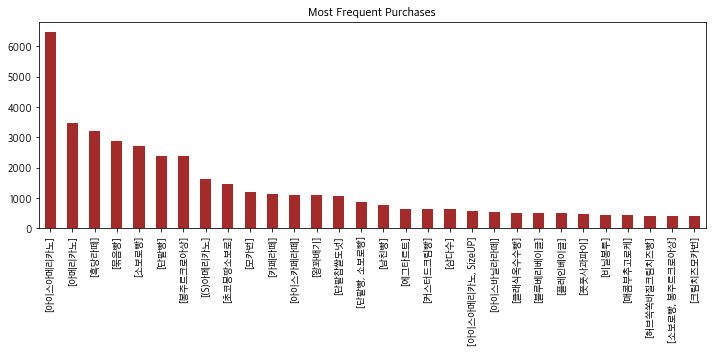

In [252]:
## BK0020 specific
fig, ax = plt.subplots(figsize=(10,5))
combos20[:30].plot(kind="bar", ax=ax, color="brown")
#ax.set_xticklabels(labels=translated)
ax.set_title("Most Frequent Purchases")
plt.tight_layout()
#plt.savefig("../plots2/top_purchases_bk20.png")

In [63]:
import pickle

with open("combos.pkl","wb") as f:
    pickle.dump(combos, f)

In [66]:
type(combos)

pandas.core.series.Series

In [166]:
combos_df = combos.reset_index()

more_than_one = combos_df[combos_df["index"].apply(lambda x: len(x)>1)]

more_than_one["sets"] = more_than_one["index"].apply(lambda x: set(x))

menu_sets = more_than_one[["sets","mname"]]

# can't groupby set data so convert it to string
menu_sets["sets_str"] = menu_sets["sets"].apply(lambda x: str(x))
menu_sets.head(20)

top_menu_sets = menu_sets.groupby("sets_str")[["mname"]].sum().sort_values(by=['mname'], ascending=False)
#top_menu_sets.to_pickle("top_menu_sets.pkl")
#top_menu_sets.to_csv("top_menu_sets.csv")

In [254]:
## BK0020 specific
combos20_df = combos20.reset_index()

more_than_one20 = combos20_df[combos20_df["index"].apply(lambda x: len(x)>1)]

more_than_one20["sets"] = more_than_one20["index"].apply(lambda x: set(x))

menu_sets20 = more_than_one20[["sets","mname"]]

# can't groupby set data so convert it to string
menu_sets20["sets_str"] = menu_sets20["sets"].apply(lambda x: str(x))
menu_sets20.head(20)

top_menu_sets20 = menu_sets20.groupby("sets_str")[["mname"]].sum().sort_values(by=['mname'], ascending=False)
#top_menu_sets.to_pickle("top_menu_sets.pkl")
#top_menu_sets.to_csv("top_menu_sets.csv")

/Users/chulgyukim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


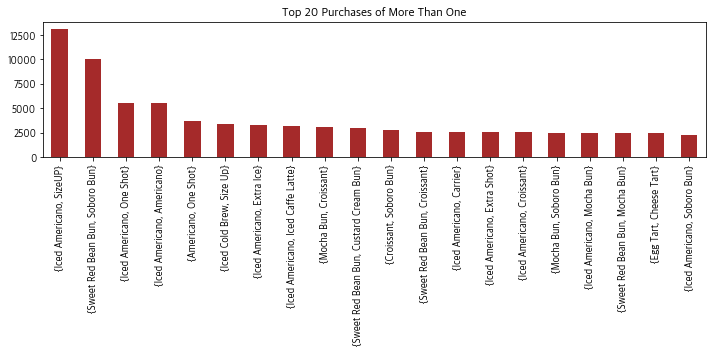

In [184]:
ticks = [
    "{Iced Americano, SizeUP}",
    "{Sweet Red Bean Bun, Soboro Bun}",
    "{Iced Americano, One Shot}",
    "{Iced Americano, Americano}",
    "{Americano, One Shot}",
    "{Iced Cold Brew, Size Up}",
    "{Iced Americano, Extra Ice}",
    "{Iced Americano, Iced Caffe Latte}",
    "{Mocha Bun, Croissant}",
    "{Sweet Red Bean Bun, Custard Cream Bun}",
    "{Croissant, Soboro Bun}",
    "{Sweet Red Bean Bun, Croissant}",
    "{Iced Americano, Carrier}",
    "{Iced Americano, Extra Shot}",
    "{Iced Americano, Croissant}",
    "{Mocha Bun, Soboro Bun}",
    "{Iced Americano, Mocha Bun}",
    "{Sweet Red Bean Bun, Mocha Bun}",
    "{Egg Tart, Cheese Tart}",
    "{Iced Americano, Soboro Bun}"
]
fig, ax = plt.subplots(figsize=(10,5))
top_menu_sets[:20].plot(kind="bar", ax=ax, color="brown")
ax.set_xticklabels(labels=ticks)
ax.set_title("Top 20 Purchases of More Than One")
plt.xlabel("")
ax.legend().set_visible(False)
plt.tight_layout()
plt.savefig("../plots2/top_20_more_than_one.png")

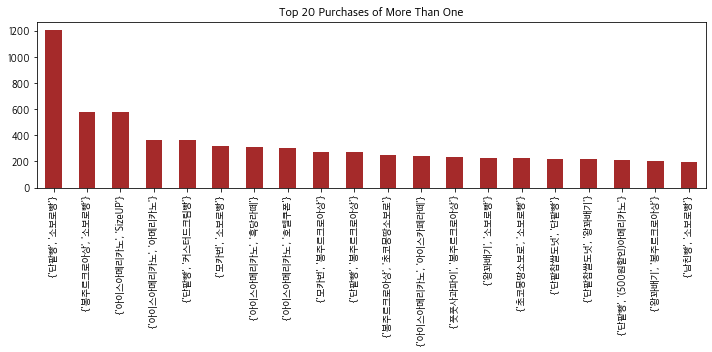

In [255]:
## BK0020 specific
fig, ax = plt.subplots(figsize=(10,5))
top_menu_sets20[:20].plot(kind="bar", ax=ax, color="brown")
#ax.set_xticklabels(labels=ticks)
ax.set_title("Top 20 Purchases of More Than One")
plt.xlabel("")
ax.legend().set_visible(False)
plt.tight_layout()
#plt.savefig("../plots2/top_20_more_than_one.png")

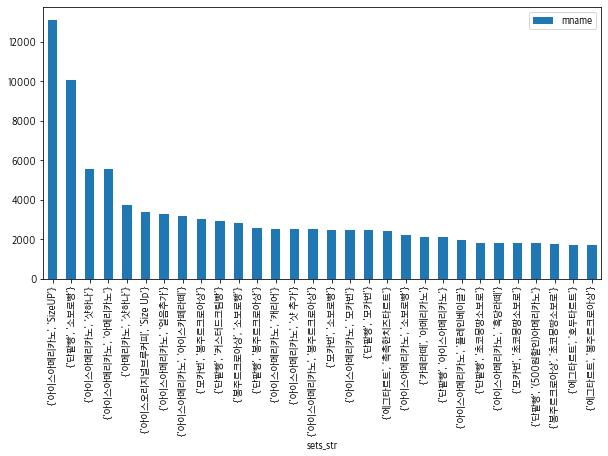

In [178]:
fig, ax = plt.subplots(figsize=(10,5))
top_menu_sets[:30].plot(kind="bar", ax=ax)